<a href="https://colab.research.google.com/github/ShonenGuru/AI-in-Renewables/blob/main/Data_preprocessing_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Generating Data

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define the starting date and time
start_date = datetime(2024, 10, 30, 6, 0, 0)
end_date = start_date + timedelta(days=30)  # Generate data for a month

# Initialize lists to store generated data
timestamps = []
temperature_c = []
irradiance_w_m2 = []
humidity_percent = []
wind_speed_ms = []
voltage_v = []
current_a = []
power_output_w = []
cloud_cover_percent = []

# Define diurnal pattern for irradiance (higher during noon, lower in the morning/evening)
for hour in range((end_date - start_date).days * 24):
    current_time = start_date + timedelta(hours=hour)
    timestamps.append(current_time)

    # Generate temperature values (slightly randomized, peaking in the afternoon)
    temp = 15 + 10 * np.sin((current_time.hour - 6) * np.pi / 12) + np.random.normal(0, 1.5)
    temperature_c.append(round(temp, 1))

    # Generate irradiance values (0 at night, peaks around noon)
    if 6 <= current_time.hour <= 18:
        irradiance = max(0, 1000 * np.sin((current_time.hour - 6) * np.pi / 12) + np.random.normal(0, 50))
    else:
        irradiance = 0
    irradiance_w_m2.append(round(irradiance))

    # Humidity fluctuates throughout the day, generally higher in the morning and evening
    humidity = max(45, 80 - 10 * np.cos((current_time.hour - 6) * np.pi / 12) + np.random.normal(0, 5))
    humidity_percent.append(round(humidity))

    # Wind speed varies randomly
    wind_speed = max(0, np.random.normal(3, 1))
    wind_speed_ms.append(round(wind_speed, 1))

    # Voltage increases with irradiance up to a limit, then stabilizes
    voltage = 20 + (irradiance / 50) if irradiance < 1000 else 40 + np.random.normal(0, 1)
    voltage_v.append(round(voltage, 1))

    # Current increases with irradiance and stabilizes at high irradiance
    current = 0 if irradiance == 0 else irradiance / 120 + np.random.normal(0, 0.5)
    current_a.append(round(current, 1))

    # Power output is a product of voltage and current
    power_output = voltage * current
    power_output_w.append(round(power_output, 1))

    # Cloud cover varies randomly but correlates inversely with irradiance
    cloud_cover = max(0, 100 - (irradiance / 10) + np.random.normal(0, 10))
    cloud_cover_percent.append(round(cloud_cover))

# Create the DataFrame
solar_data = pd.DataFrame({
    'timestamp': timestamps,
    'temperature_c': temperature_c,
    'irradiance_w_m2': irradiance_w_m2,
    'humidity_percent': humidity_percent,
    'wind_speed_ms': wind_speed_ms,
    'voltage_v': voltage_v,
    'current_a': current_a,
    'power_output_w': power_output_w,
    'cloud_cover_percent': cloud_cover_percent
})

# Save the DataFrame to a CSV file
file_path = '/mnt/data/solar_panel_data_month.csv'
solar_data.to_csv(file_path, index=False)

file_path


## Visualising Data

Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

Load Data

In [12]:
data = pd.read_csv("solar_panel_data_month.csv", parse_dates=["timestamp"])
data.set_index("timestamp", inplace=True)

Visualization 1: Temperature over time

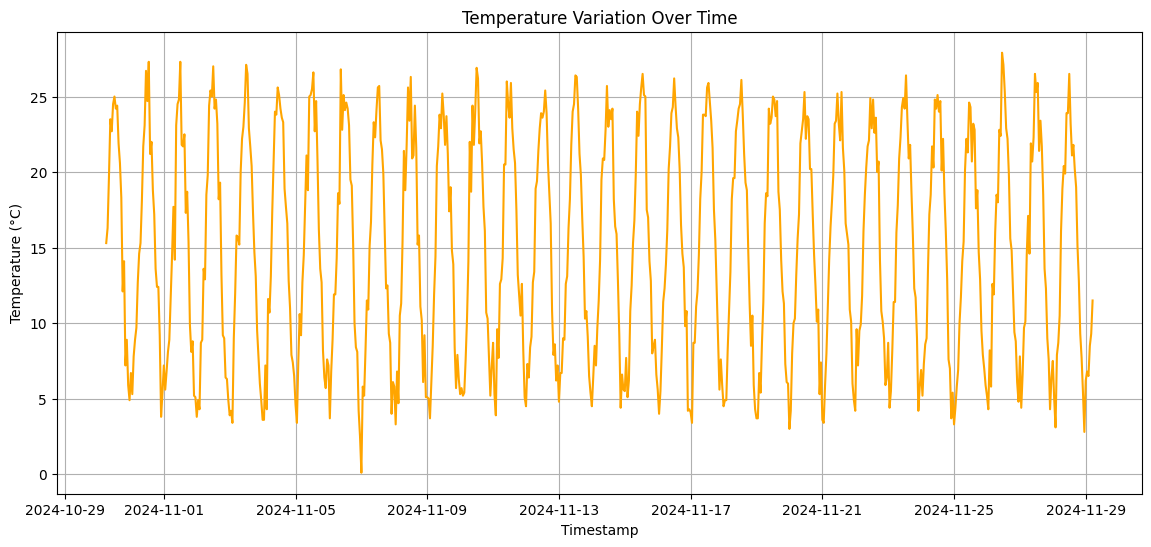

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data["temperature_c"], color='orange')
plt.title("Temperature Variation Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()

Visualization 2: Irradiance over time


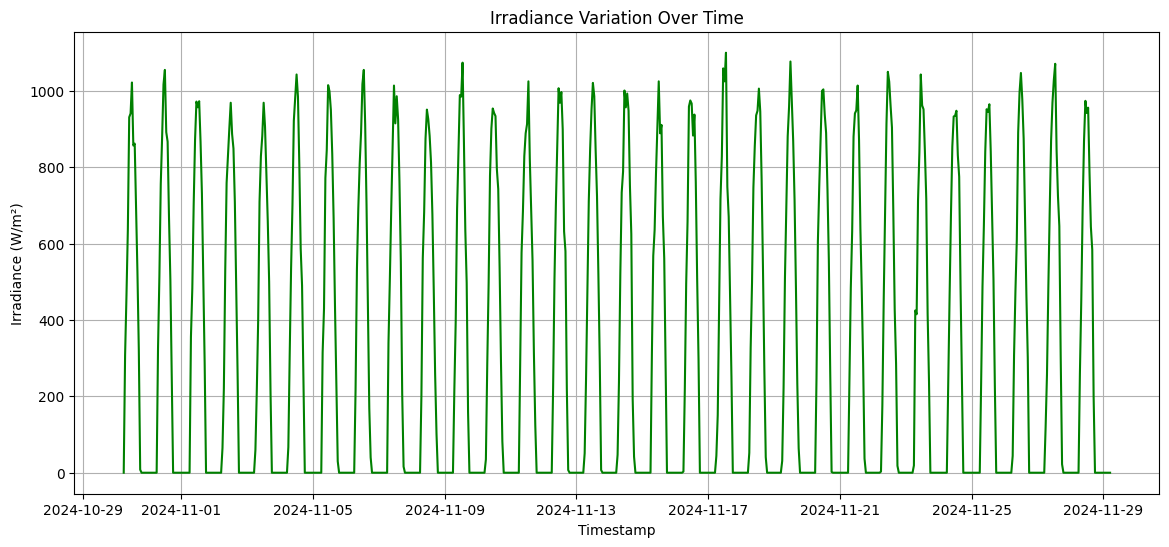

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data["irradiance_w_m2"], color='Green')
plt.title("Irradiance Variation Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.show()

Visualization 3: Power output over time


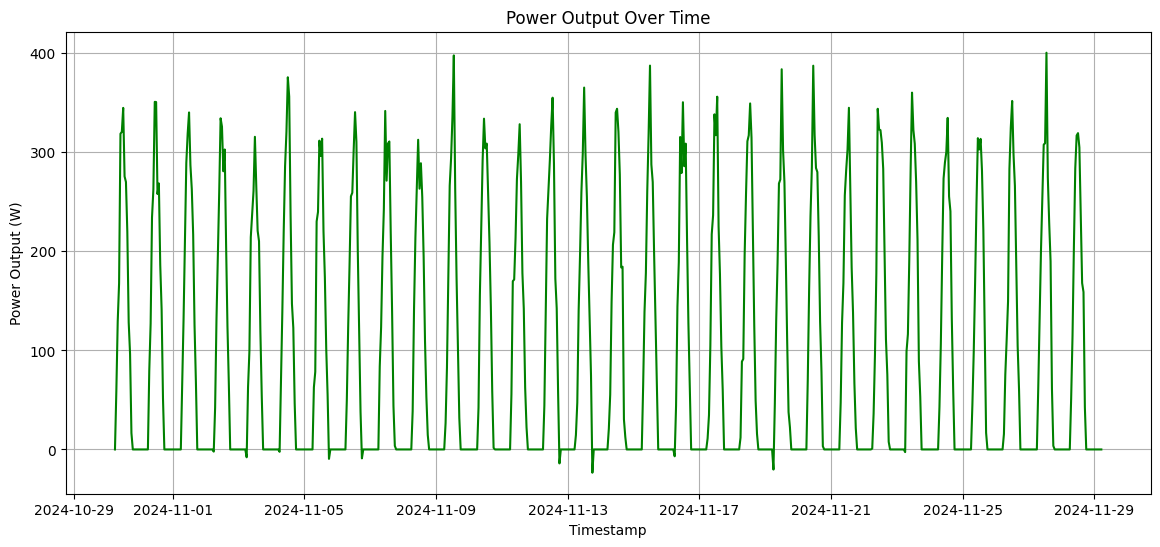

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data["power_output_w"], color='green')
plt.title("Power Output Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Power Output (W)")
plt.grid()
plt.show()

Visualization 4: Correlation Heatmap

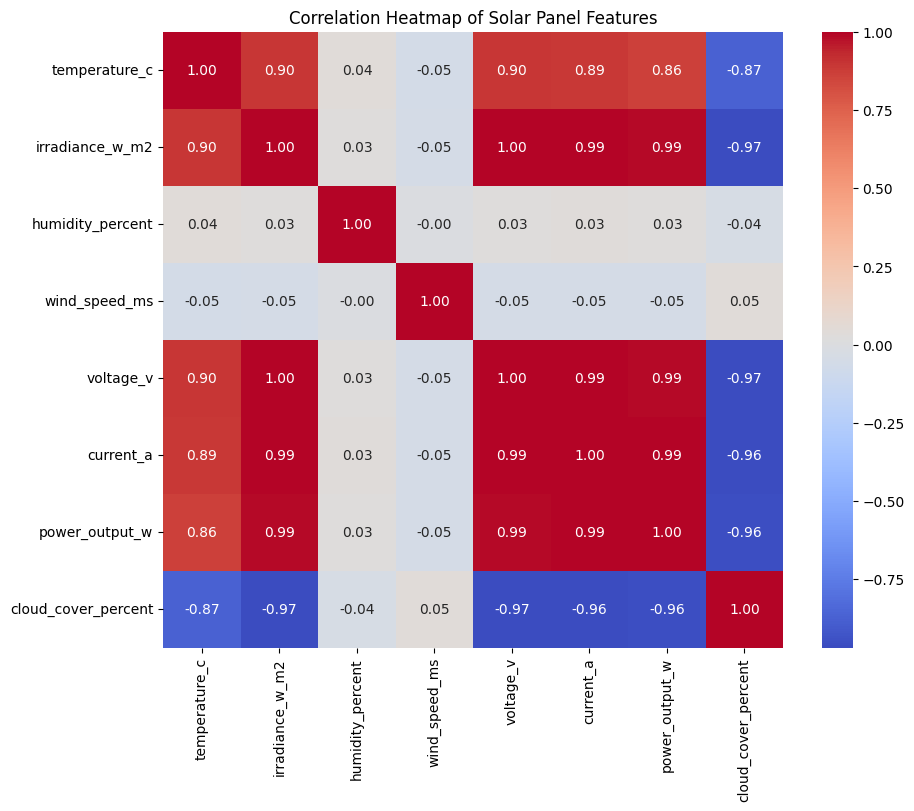

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Solar Panel Features")
plt.show()

# Data Preprocessing for LSTM
## Selecting relevant columns for prediction

In [18]:
features = ["temperature_c", "irradiance_w_m2", "humidity_percent",
            "wind_speed_ms", "cloud_cover_percent"]
target = ["power_output_w"]

## Scale the data to [0,1] range


In [32]:
scaler = MinMaxScaler()
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
data_features_scaled = scaler_features.fit_transform(data[features])
data_target_scaled = scaler_target.fit_transform(data[target])
data_scaled = np.hstack([data_features_scaled, data_target_scaled])

## Create sequences for LSTM


In [33]:
sequence_length = 24  # Using 24-hour sequences

def create_sequences(data, sequence_length):
    x = []
    y = []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i+sequence_length, :-1])  # All columns except the target
        y.append(data[i+sequence_length, -1])    # Only the target column
    return np.array(x), np.array(y)
X, y = create_sequences(data_scaled, sequence_length)

## Split into training and testing sets

In [34]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Building the LSTM Model


In [36]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

## Compile and train the model


In [37]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1051 - val_loss: 0.0741
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0635 - val_loss: 0.0356
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0245 - val_loss: 0.0131
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104 - val_loss: 0.0072
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

## Plot training and validation loss


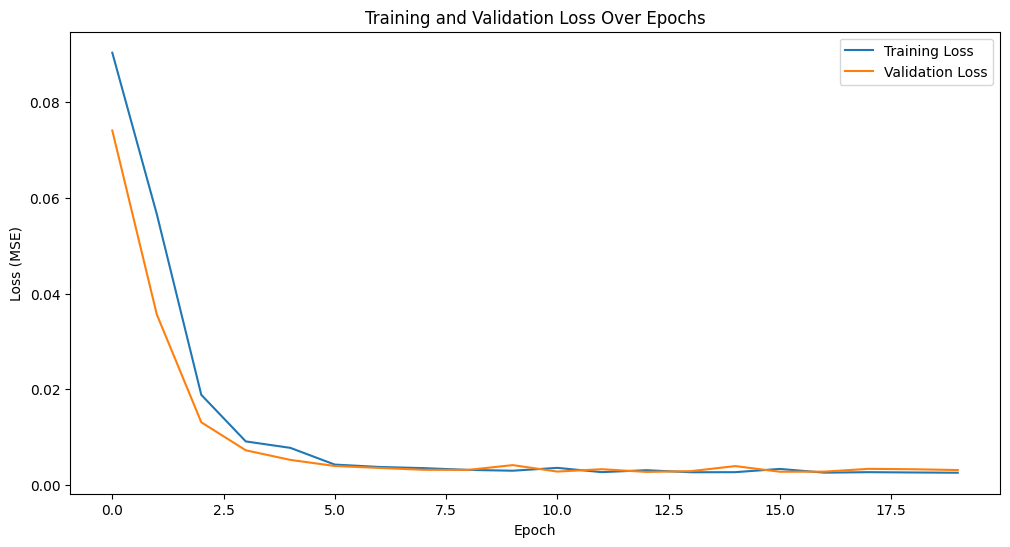

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

## Make predictions and rescale back to original values

In [39]:
y_pred = model.predict(X_test)
# y_test_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_test.reshape(-1, 1)], axis=1))[:, -1]
# y_pred_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_pred], axis=1))[:, -1]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [42]:
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()


In [43]:
y_pred_rescaled = scaler_target.inverse_transform(y_pred).flatten()


## Plot predictions vs actual values


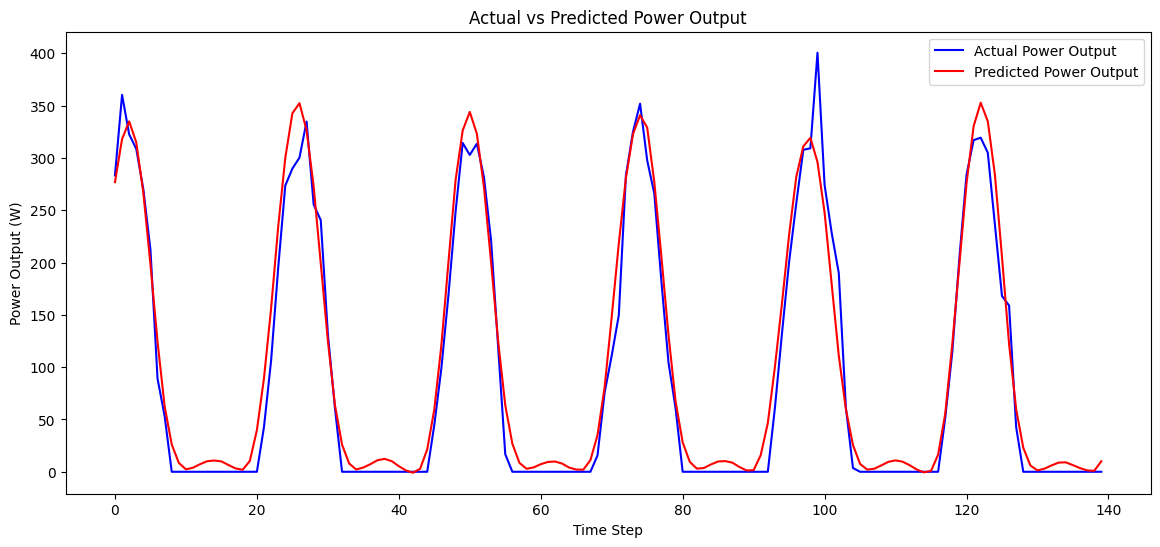

In [44]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled, label="Actual Power Output", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Power Output", color="red")
plt.title("Actual vs Predicted Power Output")
plt.xlabel("Time Step")
plt.ylabel("Power Output (W)")
plt.legend()
plt.show()